In [2]:
import os
import re
import cv2 # opencv library
import numpy as np
from os.path import isfile, join
import matplotlib.pyplot as plt

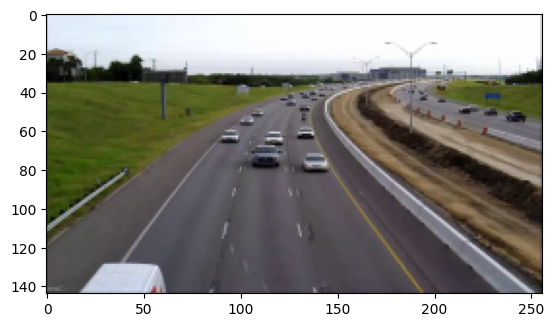

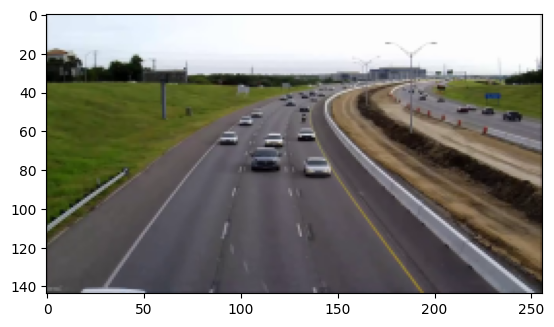

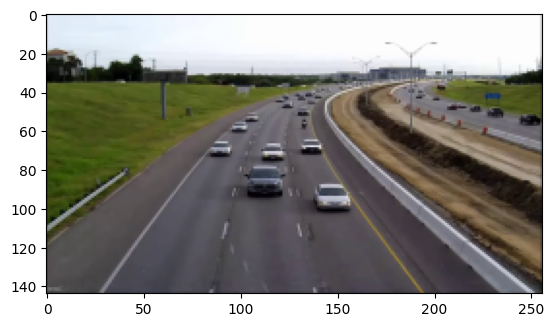

In [3]:
# Sort our images
frames = os.listdir('frames')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# List to hold our frames
images = []

# Copy our frames over into our empty list of images
for i in frames:
    img = cv2.imread('frames/' + i)
    images.append(img)

# Lets look at our first, second, and tenth frame:
for frame in [0, 1, 9]:
    plt.imshow(cv2.cvtColor(images[frame], cv2.COLOR_BGR2RGB))
    plt.show()

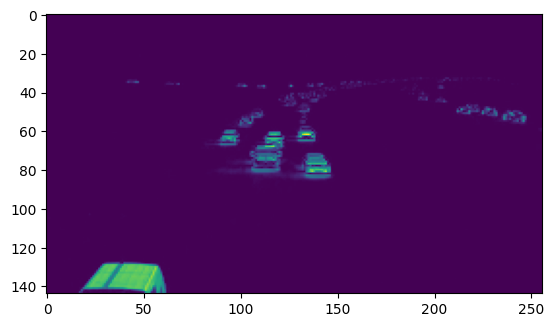

In [4]:
grayA = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(images[1], cv2.COLOR_BGR2GRAY)

plt.imshow(cv2.absdiff(grayA, grayB))

The image above highlights the differences between the first and second frame.
Next we'll apply thresholding and dilation to the image above, to make vehicles more identifiable for computer recognition

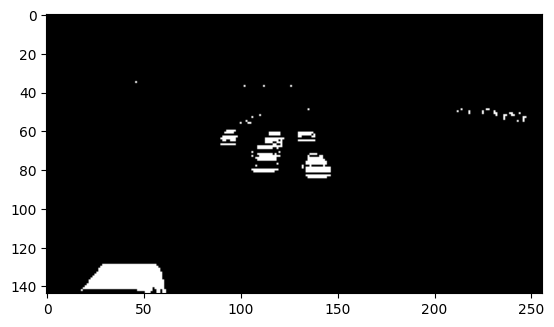

In [5]:
diff_img = cv2.absdiff(grayA, grayB)

# Applying thresholding:
retval, thresh = cv2.threshold(diff_img, 50, 255, cv2.THRESH_BINARY)

# plot our post-threshold image:
plt.imshow(thresh, cmap = 'gray')

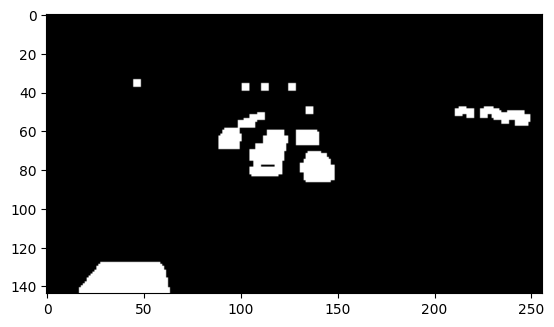

In [6]:
# Applying dilation:
kernel = np.ones((4, 4), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations = 1)

plt.imshow(dilated, cmap = 'gray')

Now we can see separate 'blobs' for each vehicle. Next we'll create an arbitrary line that we'll count cars passing through.
plt.imshow(dilated)
cv2.line(dilated, (0, 80), (256, 80), (200, 0, 0))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

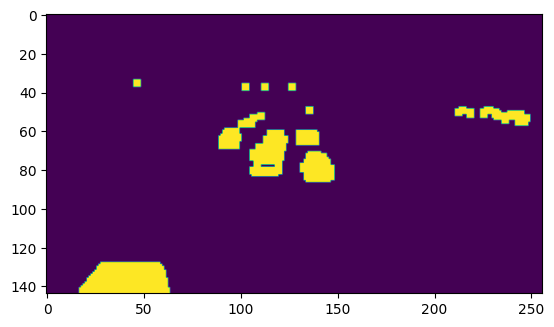

In [7]:
plt.imshow(dilated)
cv2.line(dilated, (0, 80), (256, 80), (100, 0, 0))

In [8]:
# Finding contours:
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

valid_cntrs = []
min_area = 25
max_x = 200
min_y = 80

for cntr in contours: # Iterate through every contour
    x, y, w, h = cv2.boundingRect(cntr) # Create a rectangle around each identified shape
    contour_area = cv2.contourArea(cntr)
    
    if (x <= max_x) and (y >= min_y) and (contour_area >= min_area):
        valid_cntrs.append(cntr)

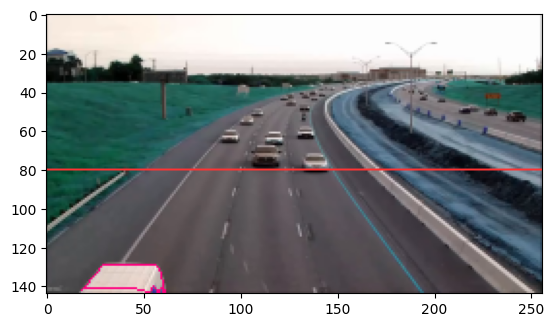

In [9]:
# Plot our contours around first frame
orig = images[0].copy()
cv2.drawContours(orig, valid_cntrs, -1, (255, 0, 127), 1)
cv2.line(orig, (0, 80), (256, 80), (255, 51, 51))
plt.imshow(orig)

Using what we just learned, we'll apply the same concepts to every pair of frames in order to create a video.
We'll process each frame, find and write contours, write our line, and count the number of cars crossing the line
Then we'll save each edited frame and export them as a video.

In [21]:
# Dilation kernel:
kernelvid = np.ones((5, 5), np.uint8) # 5x5 might seem a bit too much, but in practice it actually works best (on this dataset)

pathIn = 'frames'
font = cv2.FONT_HERSHEY_PLAIN
origin = (55, 15)

for i in range(len(images) - 1):

    # Finding difference frames:
    grayAvid = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    grayBvid = cv2.cvtColor(images[i + 1], cv2.COLOR_BGR2GRAY)
    diff_imgvid = cv2.absdiff(grayAvid, grayBvid)

    # Thresholding:
    retvid, threshvid = cv2.threshold(diff_imgvid, 20, 255, cv2.THRESH_BINARY)

    # Dilations:
    dilated_vid = cv2.dilate(threshvid, kernelvid, iterations = 1)

    # Finding contours:
    contoursvid, hiervid = cv2.findContours(dilated_vid.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # Find and keep valid contours:
    valid_cntr_vid = []
    for cntr in contoursvid:
        xvid, yvid, wvid, hvid = cv2.boundingRect(cntr) # Create a rectangle around each identified shape
        contour_area_vid = cv2.contourArea(cntr)
    
        if (xvid <= max_x) and (yvid >= min_y) and (contour_area_vid >= min_area):
            valid_cntr_vid.append(cntr)

    # Add contours to original frame:
    current_orig = images[i].copy()
    cv2.drawContours(current_orig, valid_cntr_vid, -1, (255, 0, 127), 1)

    # Add text and line to original frame:
    cv2.putText(current_orig, 'Current vehicle count: ' + str(len(valid_cntr_vid)), origin, font, .5, (0, 200, 0), 1)
    cv2.line(current_orig, (0, 80), (256, 80), (255, 51, 51))
    cv2.imwrite(pathIn + str(i) + '.png', current_orig)

Now that we have all of our frames with the desired markings and identifications, it's time to stack and turn them into a video!

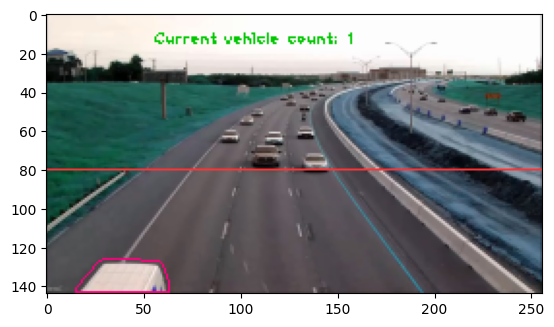

In [41]:
pathOut = 'vehicle_detection_vid1.mp4'
fps = 14.0

frame_arr = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

files.sort(key = lambda f: int(re.sub('\D', '', f)))
for i in range(len(files)):
    filename = pathIn + files[i]
    # Read our frames:
    curr_img = cv2.imread(filename)
    if (i == 0):
        plt.imshow(curr_img)
    height, width, layers = img.shape
    size = (width, height)
    # adding to frame array
    frame_arr.append(curr_img)

In [43]:
# Creating the actual video using opencv's VideoWriter
out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_arr)):
    out.write(frame_arr[i])

out.release()